# Credit Card Customer Segmentation

In this project I will be working with data from a fictional credit card company. The dataset contains information about the company’s clients and I've been asked to help segment them into different groups in order to apply different business strategies for each type of customer.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Data Exploration

In [2]:
# read the data into a dataframe
customers = pd.read_csv('data\customer_segmentation.csv')

In [3]:
print(f'shape of the dataset {customers.shape}')

shape of the dataset (10127, 14)


The dataset contains 10,127 rows and 14 columns

In [4]:
customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


The `customer_id` column does not appear to be useful

In [5]:
customers.dtypes.value_counts()

int64      9
object     3
float64    2
dtype: int64

There are 3 categorical columns:
- `gender`
- `education_level`
- `marital_status`

These can be encoded using `pd.get_dummies` or `map()` before analysis.

In [6]:
customers.isna().sum()

customer_id                 0
age                         0
gender                      0
dependent_count             0
education_level             0
marital_status              0
estimated_income            0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
credit_limit                0
total_trans_amount          0
total_trans_count           0
avg_utilization_ratio       0
dtype: int64

There are no nulls in the dataset

D:\TEMP\ipykernel_9496\2886762161.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(round(customers.corr(),2),annot=True)


<Axes: >

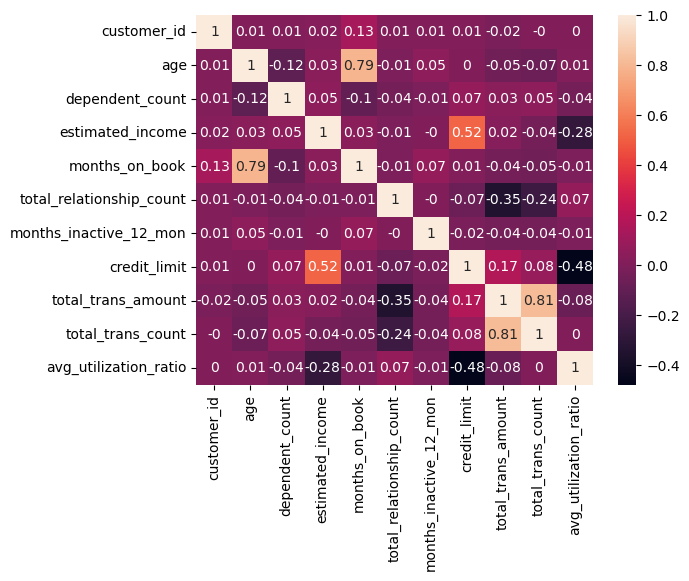

In [7]:
sns.heatmap(round(customers.corr(),2),annot=True)

`credit_limit` has positive correlation with `estimated_income` and negative correlation with `avg_utilization_ratio`.  
`total_trans_amount` and `total_trans_count` have a strong positive correlation, which is to be expected.  
`age` and `months_on_book` also have a strong positive correlation

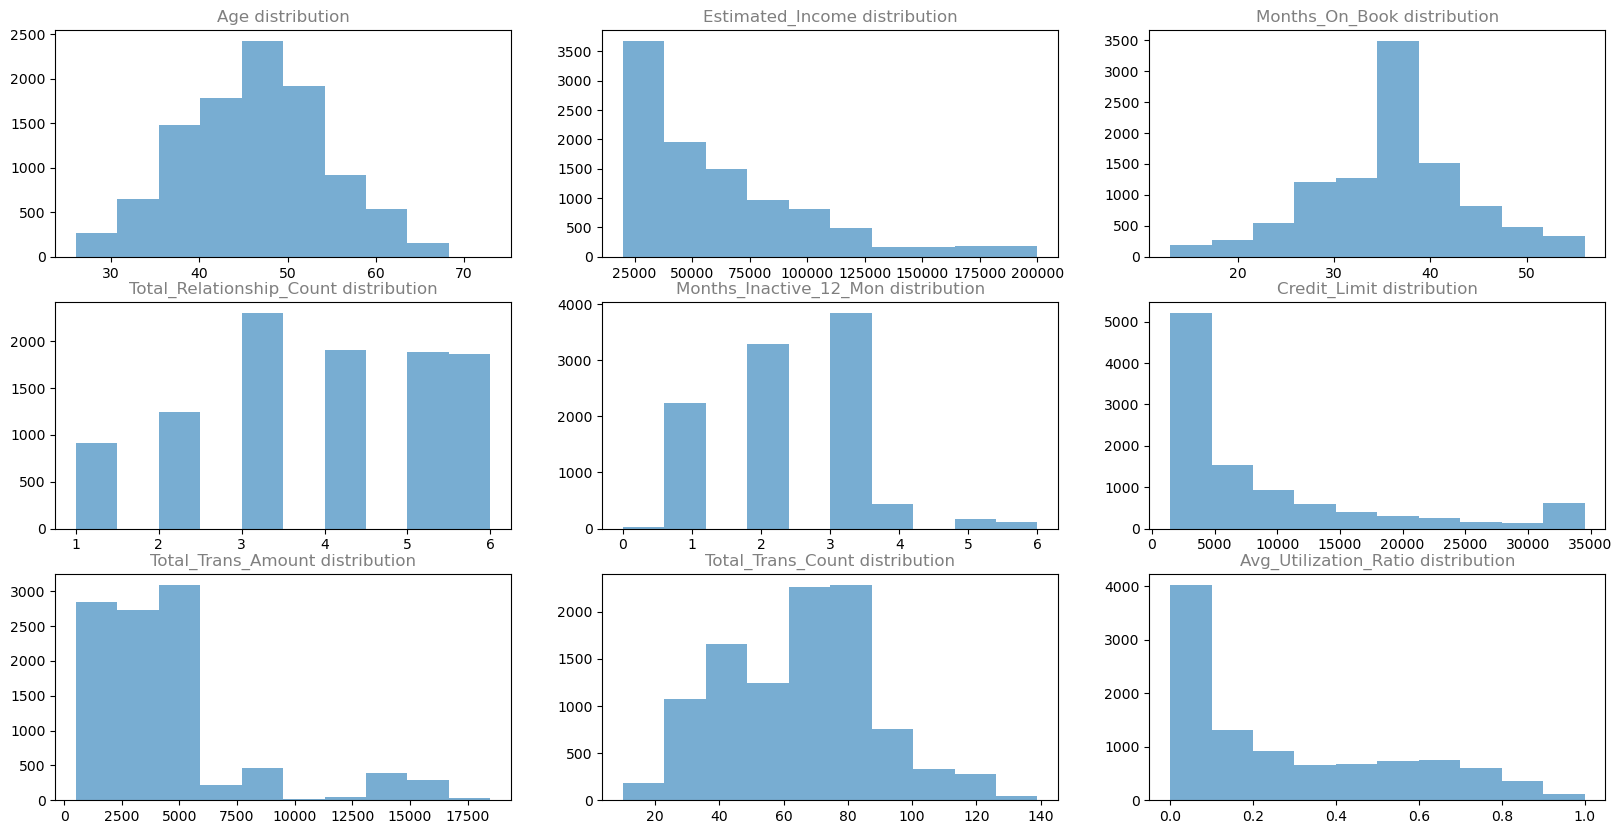

In [8]:
continous_cols = ['age',  'estimated_income', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon',
                  'credit_limit', 'total_trans_amount', 'total_trans_count', 'avg_utilization_ratio']

fig = plt.figure(figsize=(20, 10))
for i, column in enumerate(continous_cols):
    ax = fig.add_subplot(3, 3, i+1)
    ax.hist(customers[column], alpha=0.6)
    ax.set_title(f'{column.title()} distribution', alpha=0.5)
    ax.xaxis.grid(False)

`age`, `months_on_books` and `total_trans_count` have uniform distributions.  
All the other continuous columns are right-skewed.

### Feature Engineering

The categorical columns will be encoded. `gender` andd `eduction_level` can use the `map()` function

In [9]:
# create a copy of customers
customers_modif = customers.copy()
# map gender nd eduction columns
customers_modif['gender'] = customers_modif['gender'].map({"M":0,"F":1})
customers_modif['education_level'] = customers_modif['education_level'].map({"Uneducated" : 0,
                                                                            "High School" : 1,
                                                                            "College" : 2,
                                                                            "Graduate" : 3,
                                                                            "Post-Graduate" : 4,
                                                                            "Doctorate" : 5})

In [10]:
# use get dummies for marital sttus columns
customers_modif = pd.get_dummies(customers_modif, drop_first=True)

In [11]:
customers_modif.head()

,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,0,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,818770008,49,1,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,713982108,51,0,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,769911858,40,1,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,709106358,40,0,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0


### Scaling the Data

In [12]:
# drop customer id column
X = customers_modif.drop(columns='customer_id')

In [13]:
# instantiate scaler, fit then transform dataframe
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

### Choosing K

To choose the number of clusters (K) I will need to plot the inertias of models with different K values to determine which is best

In [14]:
# calculate inerti for 10 models with  k from 1 to 10
inertias = []
for k in range(1,11):
    model = KMeans(n_clusters=k)
    model.fit_predict(X_scaled)
    inertias.append(model.inertia_)

c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\clust

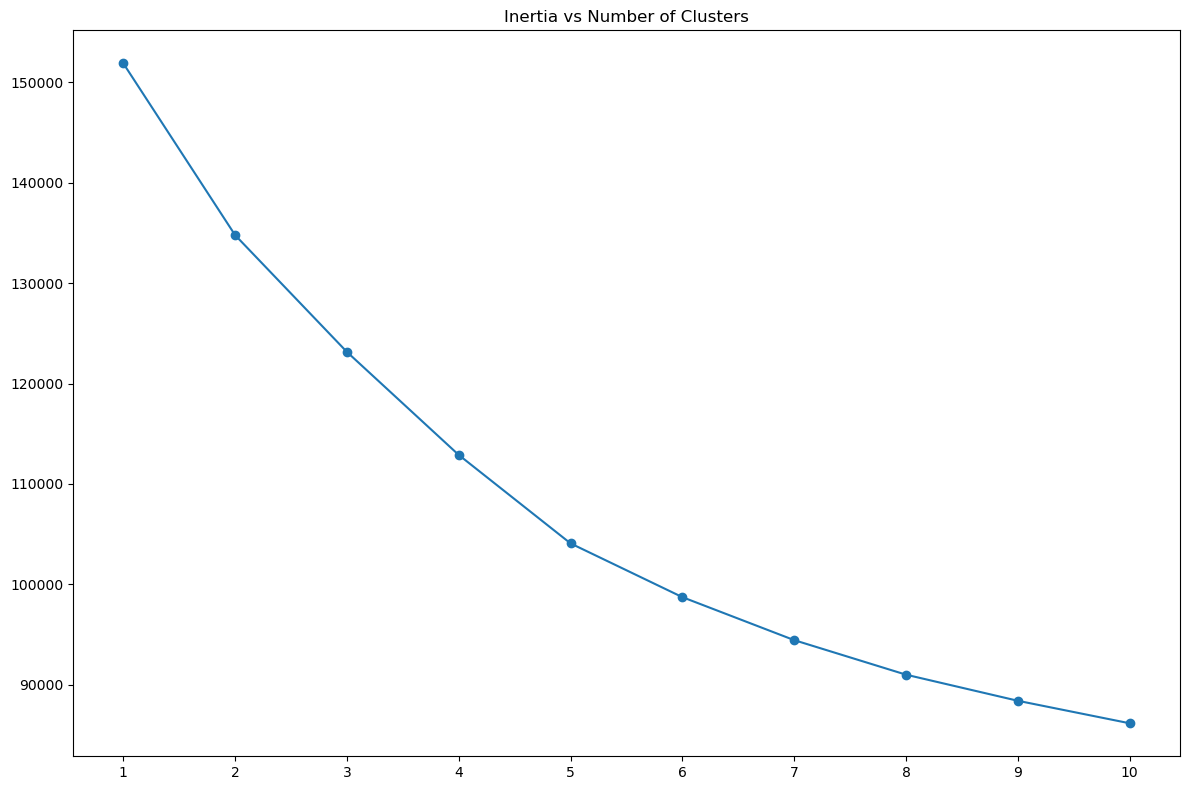

In [15]:
# plot a curve of the inertias of the 10 models
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')
plt.tight_layout()
plt.show()

Looking at the curve the decline in inertia starts to level off between 5 and 7 clusters. I will use 6 clusters for the rest of the analysis.

In [16]:
model = KMeans(n_clusters=6)
y = model.fit_predict(X_scaled)

y

c:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([2, 5, 2, ..., 1, 0, 1])

### Analysing the Results

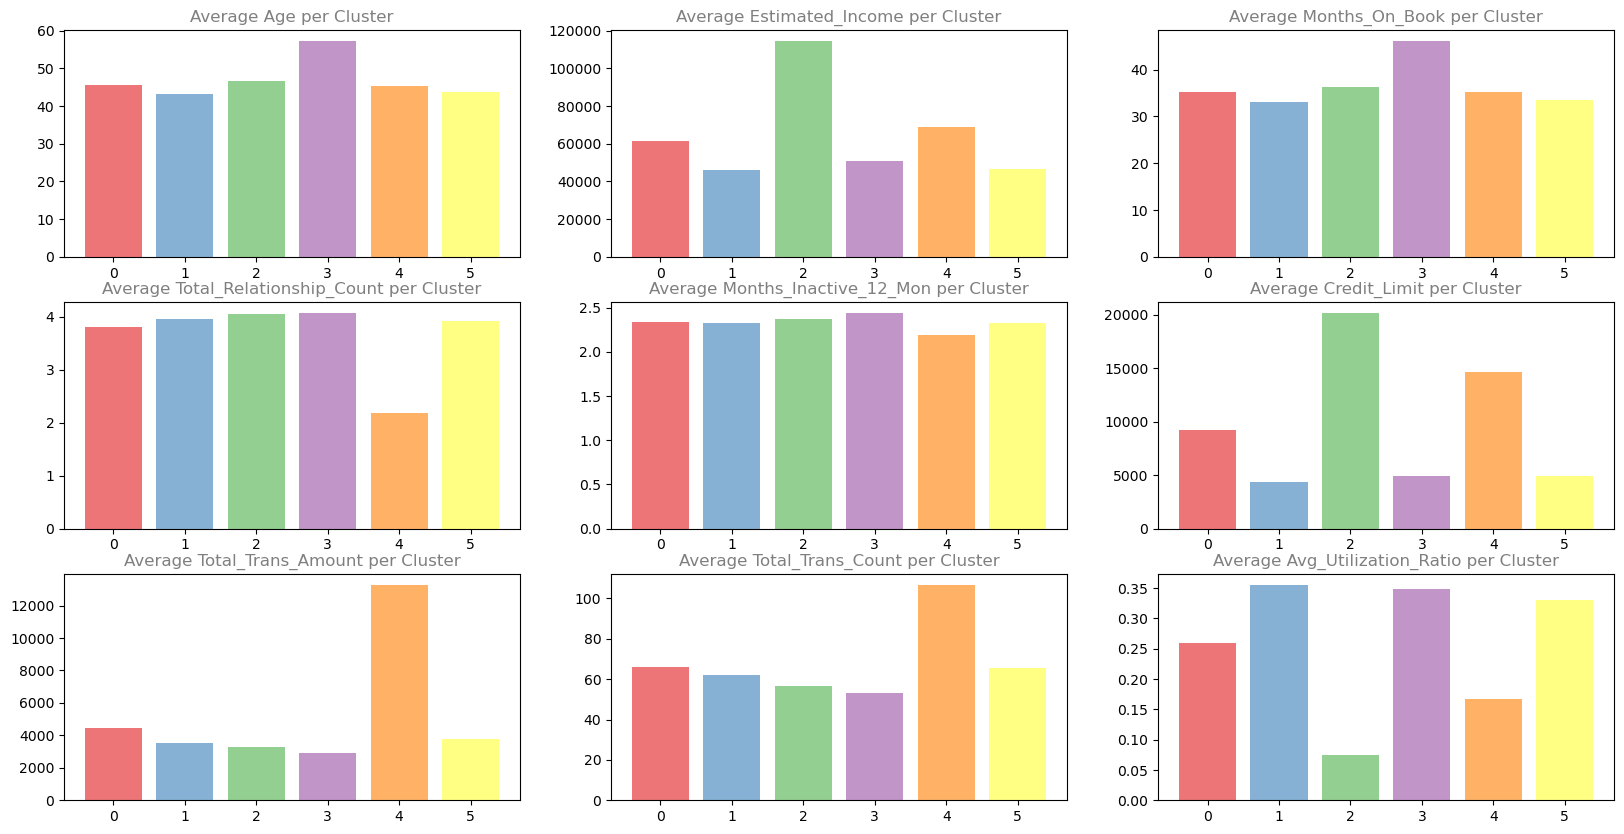

In [17]:
customers['CLUSTER'] = y
fig = plt.figure(figsize=(20, 10))
for i, column in enumerate(continous_cols):
    df_plot = customers.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(3, 3, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)

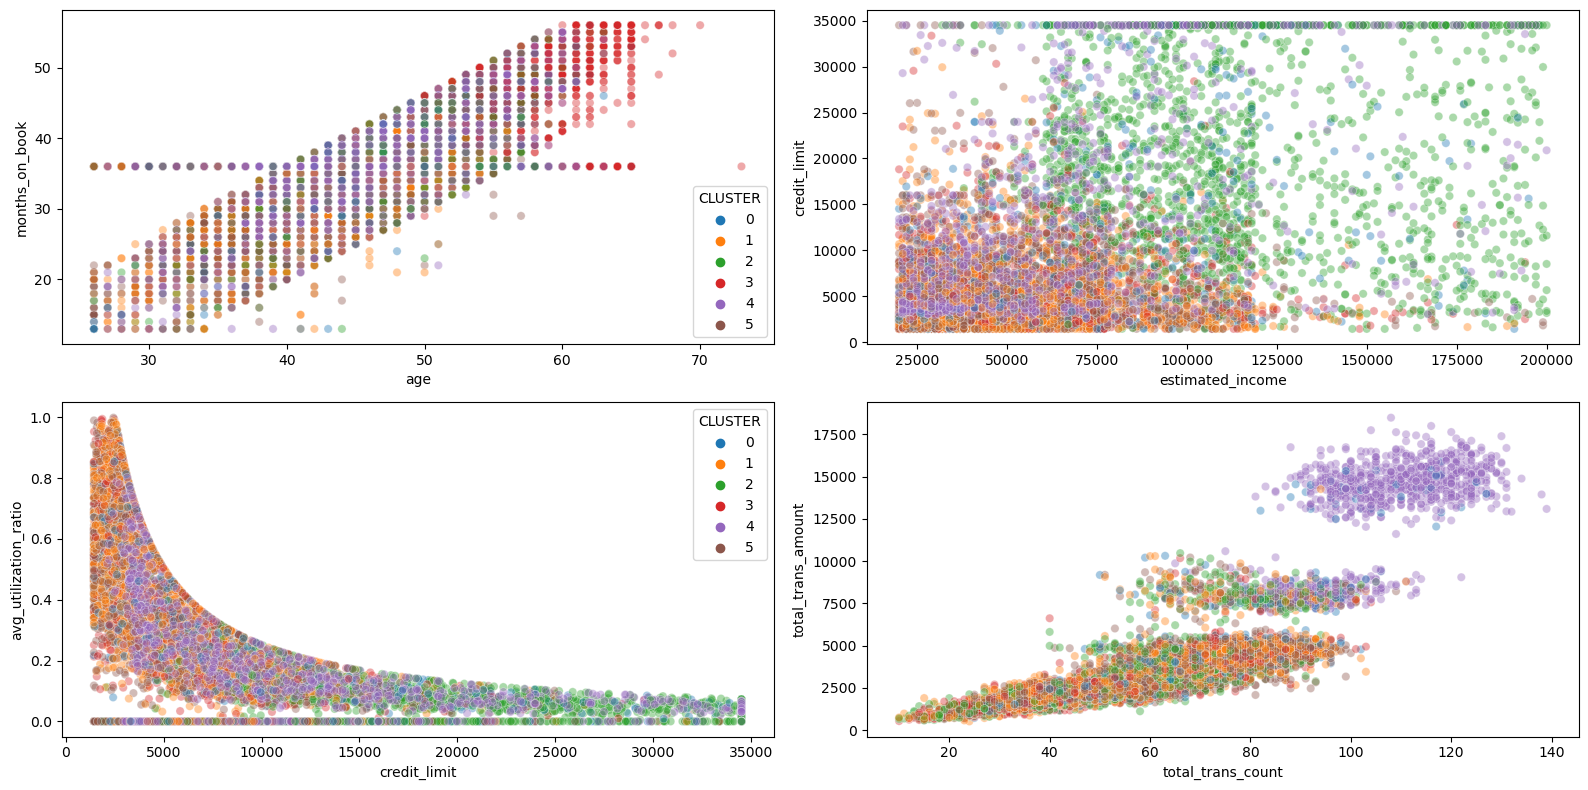

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax2, legend=False)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='CLUSTER', data=customers, palette='tab10', alpha=0.4, ax=ax4, legend=False)

plt.tight_layout()
plt.show()

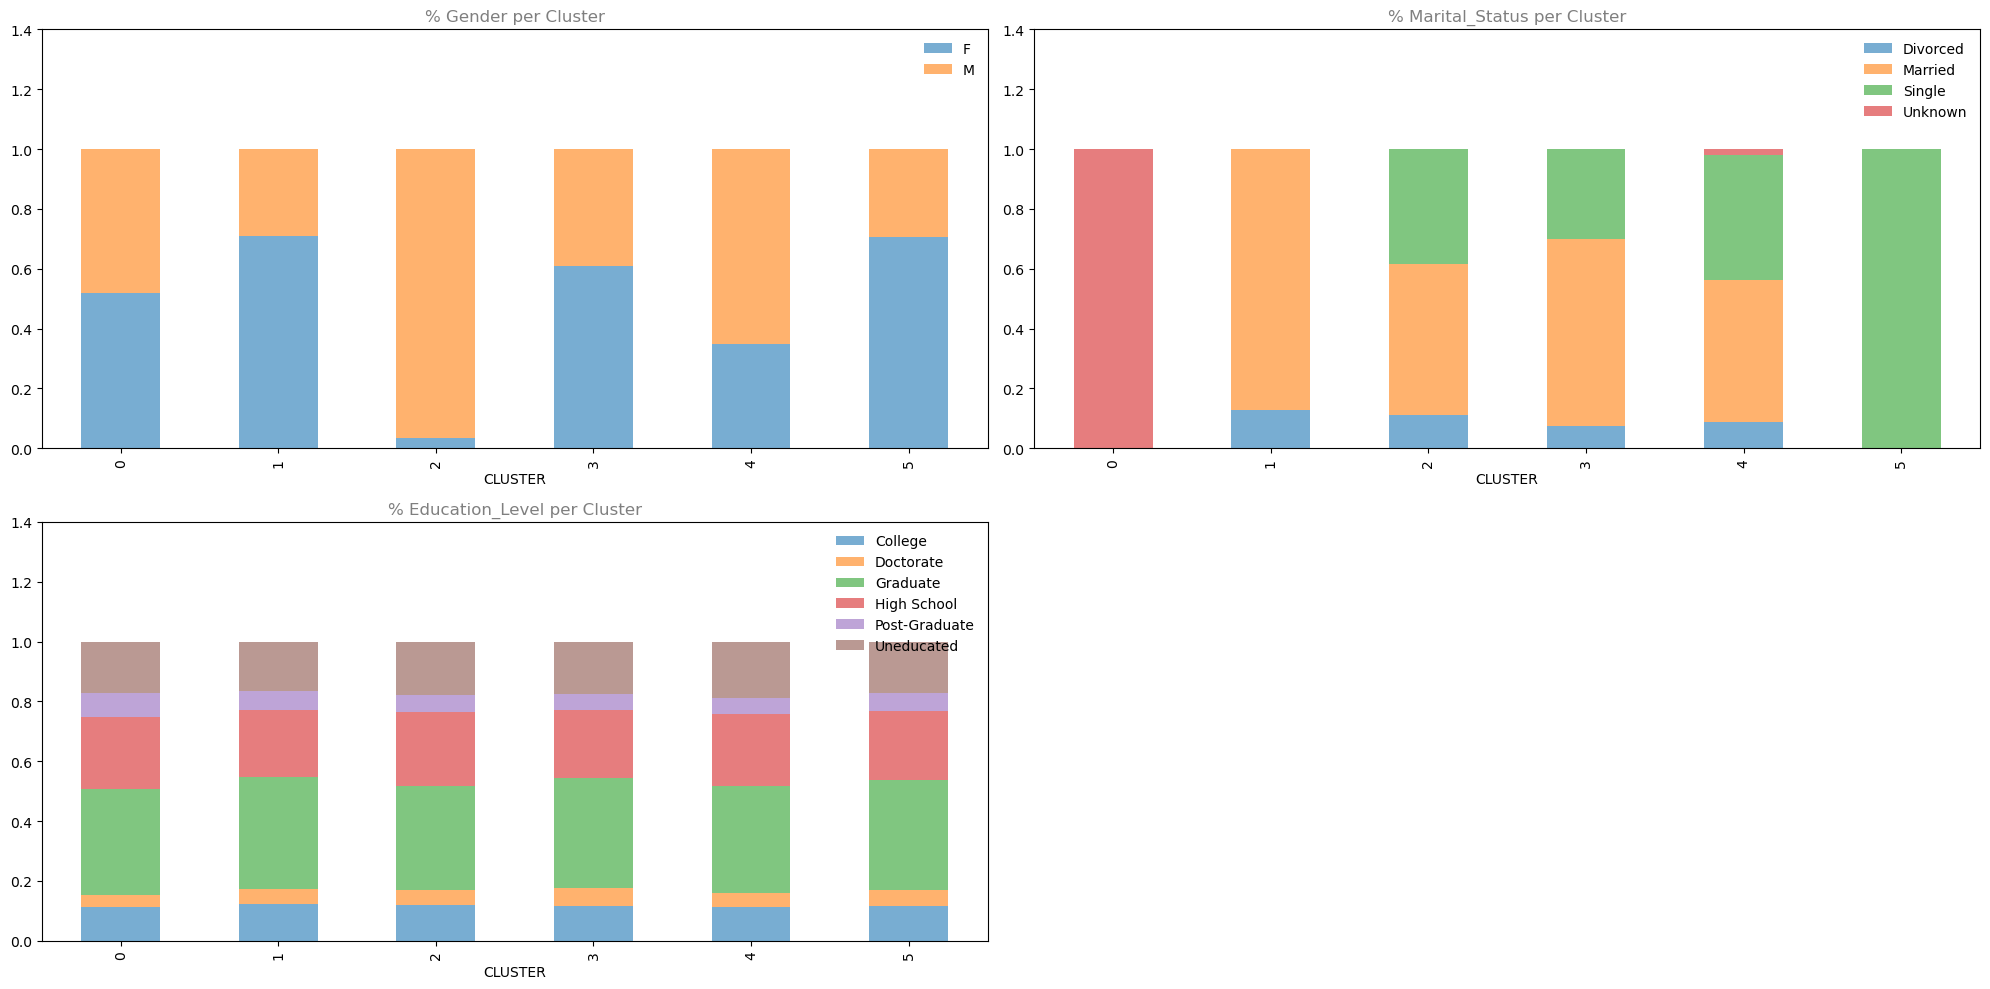

In [19]:
categorical_cols = ['gender', 'marital_status', 'education_level']
fig = plt.figure(figsize=(20, 10))
for i, column in enumerate(categorical_cols):
    plot_df = pd.crosstab(
      index=customers['CLUSTER'], columns=customers[column],
      values=customers[column], aggfunc='size', normalize='index'
)
    ax = fig.add_subplot(2,2, i+1)
    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
    ax.set_title(f'% {column.title()} per Cluster', alpha=0.5)
    ax.set_ylim(0, 1.4)
    ax.legend(frameon=False)
    ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

Characteristics of each cluster:  
Cluster 0 - Average age, Low estimated income, low credit limit, high utilisation, mainly married women  
Cluster 1 - Highest age, Averge income, Longest on book,   
Cluster 2 - Average age, Averge income, Least relaationship count, high credit limit,  
Cluster 3 - Average age, Averge income, av  
Cluster 4 - Average age, High income, high credit limit,   
Cluster 5 - Lowest age, Averge income, low credit limit,  